In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans
from colorama import Fore, Style
import seaborn as sns
from sklearn.metrics import r2_score
sns.set(style='darkgrid')
import plotly.graph_objects as go
import pickle

import sys
sys.path.append('../src') 
from stock_strategy import stock_strategy, stock_regression

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import fsolve

from kneed import KneeLocator

## Geometric Brownian motion - exploration

Given historical stock price, one can
1. Estimate the drift and volatility using mean and std of daily stock relative change
   * because dS = mu*S*dt + sigma*S*dW, so dS/S = mu*dt + sigma*dW, and mean(dS/S) = mu*dt, std(dS/S) = sigma*sqrt(dt). One can set dt = 1 and use mean and std of dS/S to calculate mu and sigma 
2. Fit the stock price to the Geometric Brownian motion model, and use MLE to estimate mu and sigma.
   * likelihood of having n observation of S where S follow geometric Brownian motion: Pi PDE(S|mu, sigma), so log-likelihood = sum(log(PDE(S|mu, sigma)); plug in the probability density function and take the log yield the log-likelihood function.

In [8]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=datetime.today(),
                    )
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed

(2517, 7)


,date,open,high,low,close,adj close,volume
0,2014-07-28,197.759995,198.089996,196.619995,197.800003,165.561371,69259000
1,2014-07-29,198.169998,198.449997,196.919998,196.949997,164.849869,80466000
2,2014-07-30,197.649994,197.910004,196.160004,196.979996,164.874985,104222000
3,2014-07-31,195.610001,195.779999,192.970001,193.089996,161.618988,183479000
4,2014-08-01,192.559998,193.759995,191.570007,192.500000,161.125137,189261000


##### Method 1

In [9]:
daily_returns = np.diff(df_spy['close']) / df_spy['close'][0:-1]
print(len(daily_returns))
print("Estimate drift:", daily_returns.mean())
print("Estimate volatility:", daily_returns.std())

2516
Estimate drift: 0.00046408513855361
Estimate volatility: 0.011108298284291582


##### Method 2

In [10]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = daily_returns.mean()  # initial guess for drift, passing the estimated drift
volatility = daily_returns.std()  # initial guess for volatility, passing the estimated volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [11]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.00046446321592546737
Volatility: 0.011144388036721024


In [12]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       197.175509
1       200.919659
2       202.391561
3       203.037628
4       200.843741
           ...    
2512    531.245023
2513    531.613743
2514    533.744585
2515    542.654102
2516    530.478443
Name: Close, Length: 2517, dtype: float64

In [13]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([197.80000305, 197.89189522, 197.98383007, ..., 635.82092514,
       636.11630917, 636.41183042])

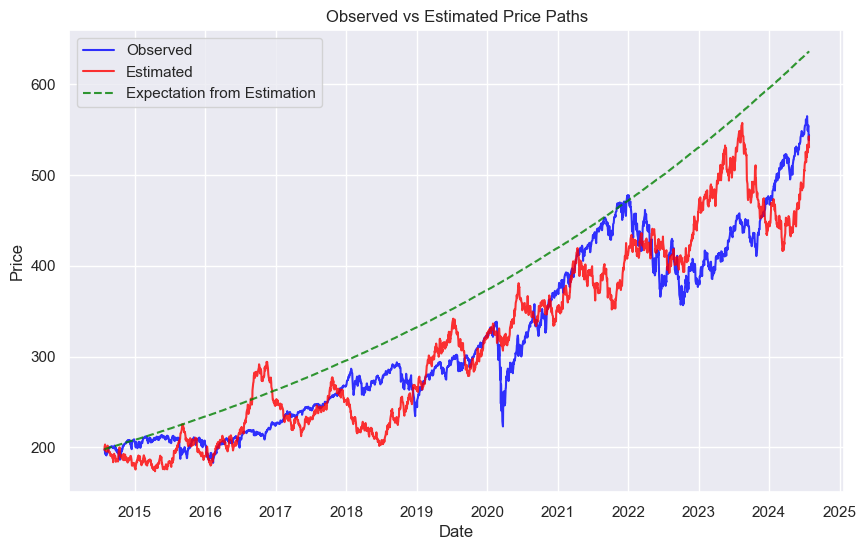

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## ML for price prediction

### Gradiant Boosting

#### Regression

In [18]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [19]:
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(483, 34)


,open,high,low,close,adj close,volume,Close_lag_1,Volume_lag_1,Close_lag_2,Volume_lag_2,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,379.940002,4153700.0,388.119995,2899000.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,379.040009,2869200.0,379.940002,4153700.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,380.190002,2241200.0,379.040009,2869200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,385.730011,2631300.0,380.190002,2241200.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,372.510010,5153200.0,385.730011,2631300.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [20]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume'])
print(features.shape)
print(features.isna().sum())
target = data['close']
print(target.shape)
print(target.isna().sum())


(483, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(483,)
0


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Mean Squared Error, train: {mse}')
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error, test: {mse}')

Mean Squared Error, train: 0.8209134357368545
Mean Squared Error, test: 20.955452951055367


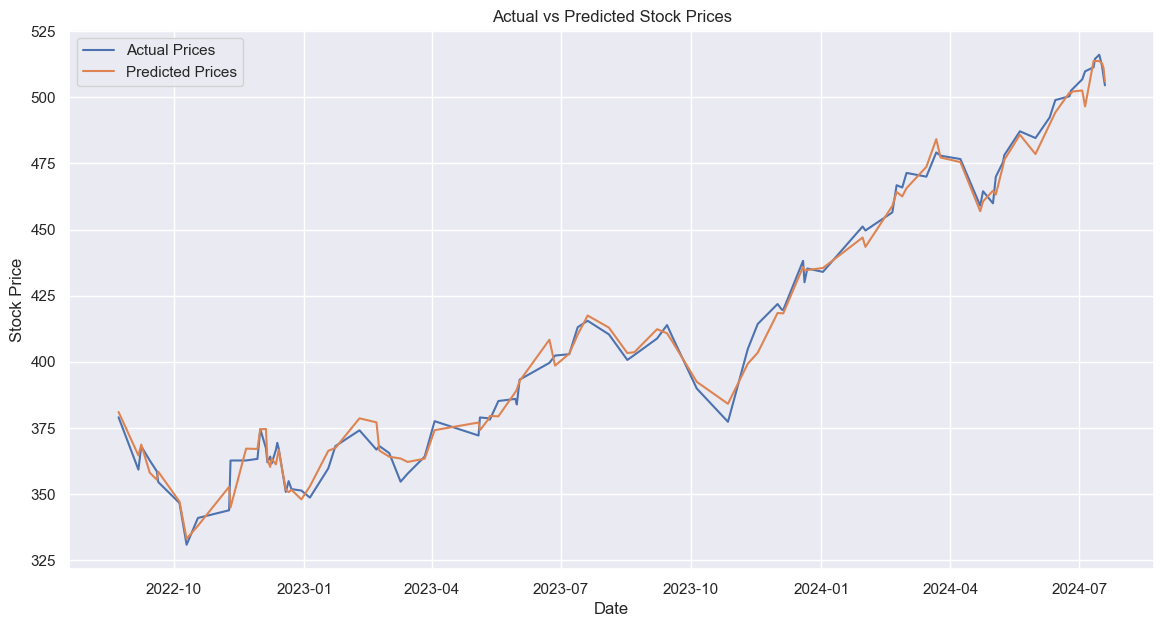

In [22]:
df_plot = pd.DataFrame()
df_plot['date'] = y_test.index
df_plot['actual'] = y_test.tolist()
df_plot['pred'] = predictions
df_plot.sort_values(by='date',inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(df_plot['date'] , df_plot['actual'] , label='Actual Prices')
plt.plot(df_plot['date'] , df_plot['pred'] , label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


<Axes: title={'center': 'Feature Importance'}, xlabel='F score', ylabel='Features'>

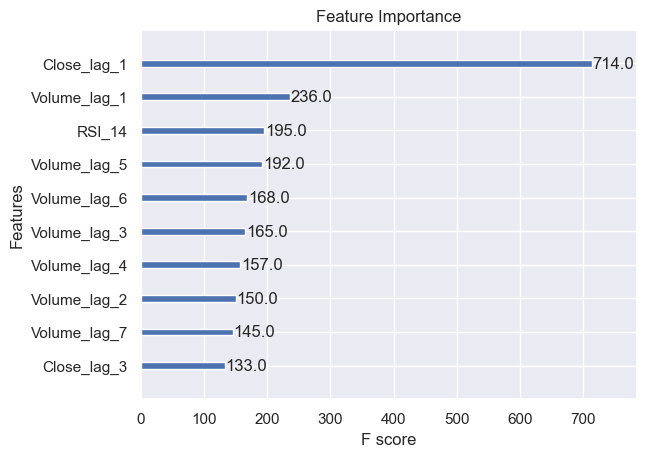

In [23]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='Feature Importance')

Build size: 434
OOT size: 49
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 1.0}
Best cross-validation score (MSE): 225.91649560261848
Mean Squared Error on Out-of-Time Test Set: 602.4927799202958


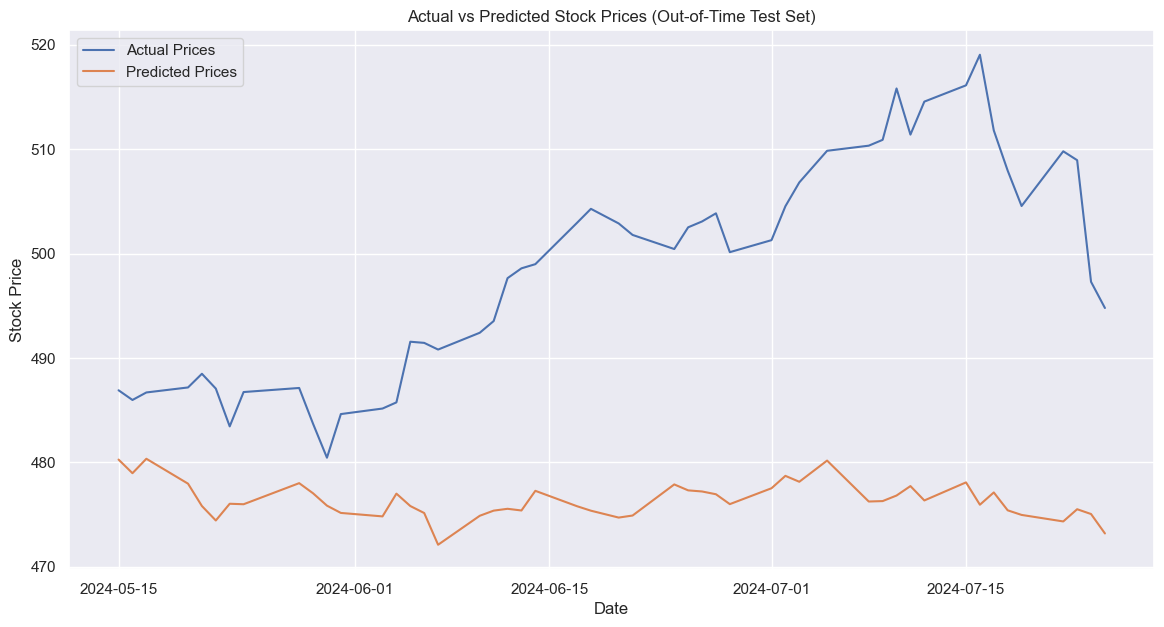

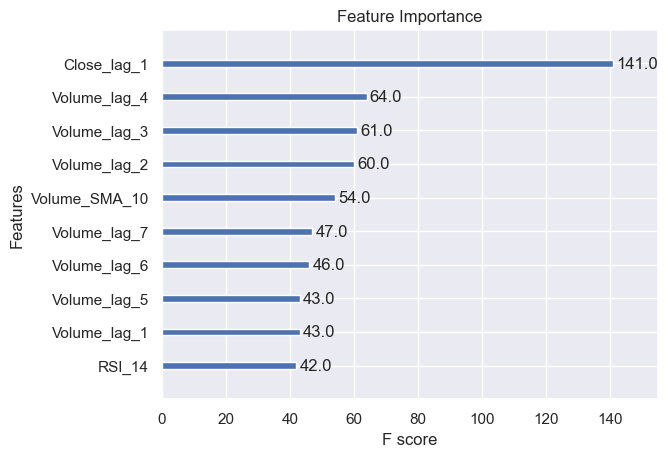

In [24]:
X_build, X_oot, y_build, y_oot = train_test_split(data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume']), 
                                                  data['close'], 
                                                  test_size=0.1, 
                                                  shuffle=False)
print('Build size:', len(y_build))
print('OOT size:', len(y_oot))

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (MSE): {-grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)

# Evaluate the model on the out-of-time test set
oot_mse = mean_squared_error(y_oot, y_oot_pred)
print(f'Mean Squared Error on Out-of-Time Test Set: {oot_mse}')

# Plotting y_oot and y_oot_pred
plt.figure(figsize=(14, 7))
plt.plot(y_oot.index, y_oot, label='Actual Prices')
plt.plot(y_oot.index, y_oot_pred, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Out-of-Time Test Set)')
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

#### Classification

In [25]:
# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [26]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64

In [27]:
# features
for lag in range(1, 8):
    data[f'Close_lag_{lag}'] = data['close'].shift(lag)
    data[f'Volume_lag_{lag}'] = data['volume'].shift(lag)

# Moving Averages (shift by 1 to avoid data leakage)
data['SMA_5'] = data['close'].rolling(window=5).mean().shift(1)
data['SMA_10'] = data['close'].rolling(window=10).mean().shift(1)
# data['SMA_20'] = data['close'].rolling(window=20).mean().shift(1) # same as data['Middle_Band']

data['EMA_5'] = data['close'].ewm(span=5, adjust=False).mean().shift(1)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean().shift(1)
data['EMA_20'] = data['close'].ewm(span=20, adjust=False).mean().shift(1)

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().shift(1)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().shift(1)
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['Middle_Band'] = data['close'].rolling(window=20).mean().shift(1)
data['Upper_Band'] = data['Middle_Band'] + 2 * data['close'].rolling(window=20).std().shift(1)
data['Lower_Band'] = data['Middle_Band'] - 2 * data['close'].rolling(window=20).std().shift(1)

# Volume-based features
data['Volume_SMA_5'] = data['volume'].rolling(window=5).mean().shift(1)
data['Volume_SMA_10'] = data['volume'].rolling(window=10).mean().shift(1)
data['Volume_SMA_20'] = data['volume'].rolling(window=20).mean().shift(1)

# Date features
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

# Drop rows with NaN values generated by rolling and shifting operations
data.dropna(inplace=True)
print(data.shape)
data.head()

(463, 36)


,open,high,low,close,adj close,volume,Max_Close_Next_20_Days,target,Close_lag_1,Volume_lag_1,...,EMA_20,RSI_14,Middle_Band,Upper_Band,Lower_Band,Volume_SMA_5,Volume_SMA_10,Volume_SMA_20,Day_of_Week,Month
date,,,,,,,,,,,,,,,,,,,,,
2022-08-23,379.559998,381.869995,378.519989,379.040009,367.145752,2869200,385.730011,0,379.940002,4153700.0,...,382.002853,55.473284,382.030502,400.523722,363.537282,3479580.0,3385310.0,3652730.0,1,8
2022-08-24,378.899994,381.579987,378.179993,380.190002,368.259674,2241200,385.730011,0,379.040009,2869200.0,...,381.720678,47.346405,383.020003,398.202442,367.837563,3280460.0,3436180.0,3646830.0,2,8
2022-08-25,381.760010,385.730011,380.700012,385.730011,373.625854,2631300,377.859985,0,380.190002,2241200.0,...,381.574899,49.258328,383.596503,397.285207,369.907798,3084240.0,3295200.0,3533875.0,3,8
2022-08-26,385.549988,386.049988,372.510010,372.510010,360.820648,5153200,377.859985,0,385.730011,2631300.0,...,381.970624,56.556446,384.217003,397.042168,371.391838,2958880.0,3200790.0,3448175.0,4,8
2022-08-29,369.769989,373.049988,368.779999,370.049988,358.437836,4953200,377.859985,0,372.510010,5153200.0,...,381.069613,43.715841,383.903003,397.567653,370.238353,3409720.0,3349670.0,3443515.0,0,8


In [28]:
features = data.drop(columns=['close', 'open', 'high', 'low', 'adj close', 'volume', 'Max_Close_Next_20_Days', 'target'])
print(features.shape)
print(features.isna().sum())
target = data['target']
print(target.shape)
print(target.isna().sum())

(463, 28)
Close_lag_1      0
Volume_lag_1     0
Close_lag_2      0
Volume_lag_2     0
Close_lag_3      0
Volume_lag_3     0
Close_lag_4      0
Volume_lag_4     0
Close_lag_5      0
Volume_lag_5     0
Close_lag_6      0
Volume_lag_6     0
Close_lag_7      0
Volume_lag_7     0
SMA_5            0
SMA_10           0
EMA_5            0
EMA_10           0
EMA_20           0
RSI_14           0
Middle_Band      0
Upper_Band       0
Lower_Band       0
Volume_SMA_5     0
Volume_SMA_10    0
Volume_SMA_20    0
Day_of_Week      0
Month            0
dtype: int64
(463,)
0


<Axes: ylabel='Frequency'>

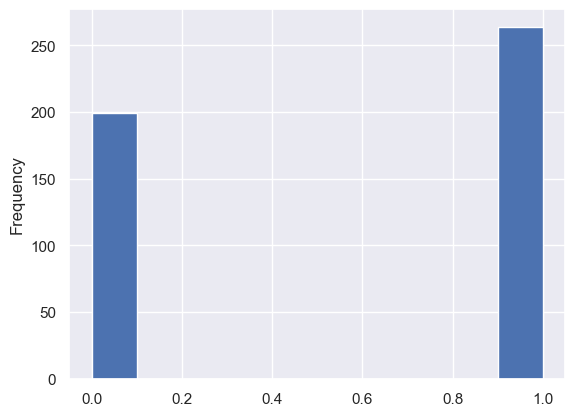

In [29]:
data['target'].plot(kind='hist')

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a GBM model
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC-ROC score
precision = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

Precision on test set: 0.8276
AUC-ROC score on test set: 0.9057
F1 score on test set: 0.8807


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ts_en

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score (AUC): 0.8040572877602772
Precision on test set: 0.5139
AUC-ROC score on test set: 0.3857
F1 score on test set: 0.5736


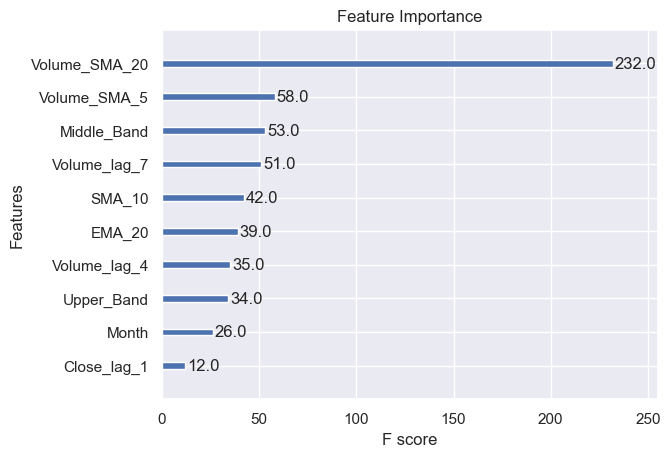

In [31]:
X_build, X_oot, y_build, y_oot = train_test_split(features, target, test_size=0.2, shuffle=False)

# Fine-tune the model using GridSearchCV with 5-fold cross-validation
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)

grid_search.fit(X_build, y_build)

# Report cross-validation model performance
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score (AUC): {grid_search.best_score_}')

# Apply the optimal model to the out-of-time test set
optimal_model = grid_search.best_estimator_
y_oot_pred = optimal_model.predict(X_oot)
y_oot_pred_proba = optimal_model.predict_proba(X_oot)[:, 1]

# Calculate accuracy and AUC-ROC score
f1 = f1_score(y_oot, y_oot_pred)
precision = precision_score(y_oot, y_oot_pred)
auc_roc = roc_auc_score(y_oot, y_oot_pred_proba)

print(f'Precision on test set: {precision:.4f}')
print(f'AUC-ROC score on test set: {auc_roc:.4f}')
print(f'F1 score on test set: {f1:.4f}')

# Plot feature importance
xgb.plot_importance(optimal_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

### LSTM

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data import
data = yf.download('VOO', start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
data = data.reset_index()
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(503, 6)


,open,high,low,close,adj close,volume
date,,,,,,
2022-07-26,362.119995,362.209991,358.450012,359.250000,347.976746,2987200
2022-07-27,362.489990,370.329987,362.220001,368.660004,357.091522,4500300
2022-07-28,369.420013,373.910004,365.980011,373.320007,361.605255,4345300
2022-07-29,374.730011,379.660004,373.929993,378.790009,366.903625,5246400
2022-08-01,376.119995,380.010010,375.440002,377.649994,365.799408,4421400


In [33]:
# create binary target: if the stock price goes 3% higher or more in the next 20 days then 1, otherwise 0 
data['Max_Close_Next_20_Days'] = data['close'].rolling(window=20, min_periods=1).max().shift(-20)
data['target'] = np.where(data['Max_Close_Next_20_Days'] >= data['close'] * 1.03, 1, 0)
data.dropna(subset=['Max_Close_Next_20_Days'], inplace=True)
print(data.shape)
data['target'].tail(21)

(483, 8)


date
2024-05-28    1
2024-05-29    1
2024-05-30    1
2024-05-31    1
2024-06-03    1
2024-06-04    1
2024-06-05    1
2024-06-06    1
2024-06-07    1
2024-06-10    1
2024-06-11    1
2024-06-12    1
2024-06-13    1
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-20    1
2024-06-21    1
2024-06-24    1
2024-06-25    1
2024-06-26    1
Name: target, dtype: int64

## ML for top / bottom identification

In [16]:
stock_name = 'voo'
stg = stock_strategy(stock_name, start='2020-04-01')
df = stg.df
df.head()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,50 Day MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff
0,2020-04-01,208.262604,212.775045,206.402386,209.892609,13710100,208.262604,208.262604,208.262604,208.262604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2020-04-02,213.134201,213.815662,206.945720,207.507472,6547000,209.886470,209.012080,208.623463,208.453647,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.388617,0.077723,0.310894
2,2020-04-03,209.984726,214.303772,207.516694,212.204096,5490200,209.919222,209.161718,208.724297,208.513689,...,NaN,NaN,NaN,NaN,NaN,NaN,58.954339,0.437421,0.149663,0.287758
3,2020-04-06,224.267960,225.897965,217.269077,218.217622,7624000,214.702134,211.485755,209.875680,209.131504,...,NaN,NaN,NaN,NaN,NaN,NaN,86.339324,1.610076,0.441746,1.168330
4,2020-04-07,224.387634,232.804702,224.203456,231.994302,12936600,217.930634,213.470660,210.950639,209.729783,...,NaN,NaN,NaN,NaN,NaN,NaN,86.421071,2.520021,0.857401,1.662620


In [22]:
print(((df['close'].shift(-10) / df['close'] - 1) < -0.05).sum())
df[((df['close'].shift(-10) / df['close'] - 1) < -0.05)]

64


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,50 Day MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff
107,2020-09-02,304.311798,305.172713,300.646068,301.719873,5273100,299.537498,295.038754,288.800975,280.346058,...,278.773477,308.128768,249.418185,NaN,NaN,89.846531,82.536502,6.237779,5.417893,0.819887
136,2020-10-14,297.149445,300.551894,296.489381,299.547898,1902100,296.587230,292.711374,289.618711,285.933813,...,288.600952,304.381439,272.820465,272.333776,NaN,73.076723,59.581909,3.092663,1.471698,1.620965
137,2020-10-15,296.796265,297.205308,293.049824,293.496032,2481700,296.656908,293.339819,290.150382,286.359791,...,288.887382,304.770716,273.004047,272.781855,NaN,69.546905,59.060873,3.189437,1.815246,1.374191
138,2020-10-16,296.545288,299.538724,296.461624,298.088491,1669600,296.619701,293.832968,290.624078,286.759222,...,289.130838,305.155266,273.106410,273.237206,NaN,65.158486,58.668247,3.208889,2.093975,1.114915
444,2022-01-04,415.556519,417.629240,413.805586,416.985634,6262200,414.491332,411.525745,407.644690,402.949485,...,404.036321,419.914268,388.158375,391.458191,378.748070,65.717473,60.861546,3.881055,3.034429,0.846626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,2025-03-21,515.392822,516.076370,509.845176,510.964609,5059000,514.597260,517.037298,525.216086,531.746774,...,537.596313,577.622401,497.570226,535.930210,520.464312,39.458423,41.722756,-8.178788,-8.397771,0.218984
1250,2025-03-24,524.437378,525.428023,520.960206,521.554568,22376300,517.877299,518.175772,525.158404,531.460131,...,537.343699,577.639251,497.048147,535.977152,520.704111,49.351073,49.135967,-6.982632,-8.114743,1.132112
1251,2025-03-25,525.685608,526.626672,524.159976,525.626172,6260200,520.480069,519.331132,525.197456,531.233679,...,537.279506,577.676742,496.882269,536.015652,520.921655,46.265740,50.079759,-5.866325,-7.665060,1.798735
1253,2025-03-27,518.124084,521.573510,516.155766,518.203567,5534900,519.488856,519.174391,524.286406,530.279497,...,536.836434,578.112363,495.560505,536.058936,521.292494,45.494330,44.602154,-5.112015,-6.794287,1.682272


In [45]:
print((df[::-1]['close'].shift(1).rolling(window=10).min()[::-1] / df['close'] - 1 < -0.05).sum())
df[(df[::-1]['close'].shift(1).rolling(window=10).min()[::-1] / df['close'] - 1 < -0.05)]

107


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff,label_tops,label_bottoms,label_topc,label_bottomc
45,2020-06-05,270.386780,272.016799,268.544971,268.563407,6015500,264.269838,258.701636,251.307540,241.925493,...,NaN,86.246408,76.719509,7.394097,6.281437,1.112659,0,0,1,0
46,2020-06-08,273.665253,273.803383,270.635468,271.141955,5559700,267.401643,261.003731,252.963667,243.170189,...,NaN,84.611597,78.635299,8.040065,6.633163,1.406902,0,0,1,0
47,2020-06-09,271.722137,272.946956,270.405250,271.197215,4686400,268.841808,262.652717,254.353183,244.289874,...,NaN,85.634013,74.711086,8.299534,6.966437,1.333097,0,0,1,0
48,2020-06-10,270.027710,272.946991,269.447535,272.154998,5602600,269.237109,263.787331,255.514259,245.299201,...,NaN,79.279910,71.366529,8.273072,7.227764,1.045308,0,0,1,0
106,2020-09-01,299.942596,300.016668,297.091479,297.896826,3008000,297.150349,293.352746,287.560109,279.367864,...,NaN,85.054849,79.058683,5.792637,5.212921,0.579716,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2025-03-31,510.867218,512.278854,499.663987,502.318161,8196700,514.012039,516.412503,522.159966,528.670335,...,521.550011,53.273239,40.865026,-5.747464,-6.400660,0.653197,0,0,0,0
1256,2025-04-01,512.746033,514.286843,505.867022,509.326398,7697000,513.590037,515.848430,521.462638,528.045852,...,521.672988,52.865168,42.553085,-5.614208,-6.243370,0.629162,0,0,0,0
1257,2025-04-02,515.837646,518.402388,506.910834,507.119613,6308600,514.339240,515.846771,521.045972,527.567099,...,521.806812,60.803275,45.319161,-5.199201,-6.034536,0.835335,1,0,0,0
1258,2025-04-03,491.234161,500.677913,490.578065,498.033659,16226000,506.637547,512.060216,518.837690,526.142278,...,521.815658,36.098632,32.080702,-6.777474,-6.183124,-0.594350,0,0,1,1


In [23]:
print(((df['close'].shift(-10) / df['close'] - 1) > 0.05).sum())
df[((df['close'].shift(-10) / df['close'] - 1) > 0.05)]

82


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,50 Day MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff
0,2020-04-01,208.262604,212.775045,206.402386,209.892609,13710100,208.262604,208.262604,208.262604,208.262604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2020-04-02,213.134201,213.815662,206.945720,207.507472,6547000,209.886470,209.012080,208.623463,208.453647,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.388617,0.077723,0.310894
2,2020-04-03,209.984726,214.303772,207.516694,212.204096,5490200,209.919222,209.161718,208.724297,208.513689,...,NaN,NaN,NaN,NaN,NaN,NaN,58.954339,0.437421,0.149663,0.287758
4,2020-04-07,224.387634,232.804702,224.203456,231.994302,12936600,217.930634,213.470660,210.950639,209.729783,...,NaN,NaN,NaN,NaN,NaN,NaN,86.421071,2.520021,0.857401,1.662620
9,2020-04-15,235.051727,236.580418,233.090196,234.904379,4888900,233.518193,225.960262,218.745116,214.361076,...,NaN,NaN,NaN,NaN,NaN,NaN,74.817849,7.215146,4.393604,2.821542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,2025-04-30,506.721924,508.471513,494.812874,500.280310,7873700,502.211749,495.986754,497.577327,506.713828,...,509.685684,569.557058,449.814310,529.612884,520.784068,55.765060,54.710049,-1.590572,-6.081405,4.490832
1277,2025-05-01,510.310516,515.370406,509.733994,512.080006,5784500,504.911338,498.190410,498.520526,506.854874,...,508.723961,565.961052,451.486870,529.503261,520.795284,69.841465,56.389182,-0.330116,-4.931147,4.601031
1279,2025-05-05,514.923096,517.766148,513.213309,514.018510,4793500,511.074296,503.294878,501.045990,507.577146,...,507.322222,560.331900,454.312543,529.131370,520.884202,64.905314,57.936307,2.248888,-2.506983,4.755871
1280,2025-05-06,510.539215,514.764052,508.908911,509.853298,4694300,510.895936,504.409392,501.749192,507.693305,...,506.652953,558.003471,455.302436,528.860307,520.936775,62.409286,55.136042,2.660200,-1.473546,4.133746


In [46]:
print((df[::-1]['close'].shift(1).rolling(window=10).max()[::-1] / df['close'] - 1 > 0.05).sum())
df[(df[::-1]['close'].shift(1).rolling(window=10).max()[::-1] / df['close'] - 1 > 0.05)]

128


Price,date,close,high,low,open,volume,5 Day EMA,12 Day EMA,26 Day EMA,50 Day EMA,...,200 Day MA,RSI_raw,RSI,MACD,MACD_signal,MACD_diff,label_tops,label_bottoms,label_topc,label_bottomc
0,2020-04-01,208.262604,212.775045,206.402386,209.892609,13710100,208.262604,208.262604,208.262604,208.262604,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,1,0,0
1,2020-04-02,213.134201,213.815662,206.945720,207.507472,6547000,209.886470,209.012080,208.623463,208.453647,...,NaN,NaN,100.000000,0.388617,0.077723,0.310894,0,1,0,0
2,2020-04-03,209.984726,214.303772,207.516694,212.204096,5490200,209.919222,209.161718,208.724297,208.513689,...,NaN,NaN,58.954339,0.437421,0.149663,0.287758,0,1,0,0
3,2020-04-06,224.267960,225.897965,217.269077,218.217622,7624000,214.702134,211.485755,209.875680,209.131504,...,NaN,NaN,86.339324,1.610076,0.441746,1.168330,0,0,0,0
4,2020-04-07,224.387634,232.804702,224.203456,231.994302,12936600,217.930634,213.470660,210.950639,209.729783,...,NaN,NaN,86.421071,2.520021,0.857401,1.662620,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,2025-05-07,512.845459,515.111928,508.073861,511.871220,5460000,511.545777,505.707248,502.571138,507.895351,...,521.017565,73.339038,56.331804,3.136111,-0.551615,3.687725,0,0,0,0
1282,2025-05-08,516.265137,521.126138,513.292789,516.463904,5088200,513.118897,507.331539,503.585508,508.223578,...,521.089661,74.354053,58.114493,3.746031,0.307914,3.438117,0,0,0,0
1283,2025-05-09,515.579224,518.541560,514.296823,517.607123,4739500,513.939006,508.600413,504.473931,508.512034,...,521.162511,87.370797,57.606508,4.126482,1.071628,3.054854,0,0,0,0
1310,2025-06-18,545.988037,549.437523,545.143094,546.902573,4602300,547.312749,546.013697,539.485170,531.501055,...,527.727062,58.885431,57.492269,6.528527,7.626135,-1.097608,0,1,0,0


In [48]:
# label: 
# for top: 
# simple: drop more than 5% after 10days
# complex: the minimal price of the next 10days drop more than 5% comparing to the current price
# for bottom: 
# simple: increase more than 5% after 10days
# complex: the maximal price of the next 10days increases more than 5% comparing to the current price
df['label_tops'] = 1*((df['close'].shift(-10) / df['close'] - 1) < -0.05)
df['label_bottoms'] = 1*((df['close'].shift(-10) / df['close'] - 1) > 0.05)
df['label_topc'] = 1*(df[::-1]['close'].shift(1).rolling(window=10).min()[::-1] / df['close'] - 1 < -0.05)
df['label_bottomc'] = 1*(df[::-1]['close'].shift(1).rolling(window=10).max()[::-1] / df['close'] - 1 > 0.05)
df.groupby(['label_topc', 'label_tops', 'label_bottomc', 'label_bottoms']).size()

label_topc  label_tops  label_bottomc  label_bottoms
0           0           0              0                1164
                        1              0                  46
                                       1                  82
1           0           0              0                  43
            1           0              0                  64
dtype: int64